# Are You Santa? 

In this exercise, we will create a binary classification model that can differentiate whether the person is a santa or not. 

Christmas is coming and we thought it will be a fun project to play with this dataset. 🎁🧑🎄

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/딥러닝/is that santa'

/content/drive/MyDrive/딥러닝/is that santa


In [ ]:
device = 'cuda'

# Data Upload

In [ ]:
# Define the paths to training and test dataset
train_directory = '/content/drive/MyDrive/딥러닝/is that santa/train'
test_directory = '/content/drive/MyDrive/딥러닝/is that santa/test'

In [ ]:
train_directory

'/content/drive/MyDrive/딥러닝/is that santa/train'

We first define the path to each of the directories. 

We will use 'os' and 'glob' libraries, which help us to define all paths to images very easily.

In [ ]:
from glob import glob
import os

train_image_path = glob(os.path.join(train_directory, '*', '*'))
test_image_path = glob(os.path.join(test_directory,'*','*'))
#check the first image path 
train_image_path[0]


'/content/drive/MyDrive/딥러닝/is that santa/train/not-a-santa/177.not-a-santa.jpg'

Now, we will check some random images in the train dataset! 

For every image we will also have it's image size and label displayed as a title.

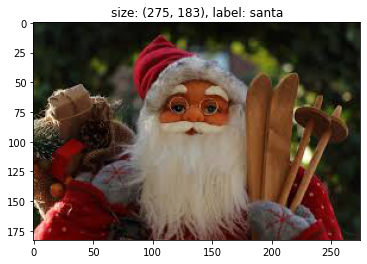

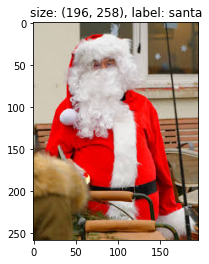

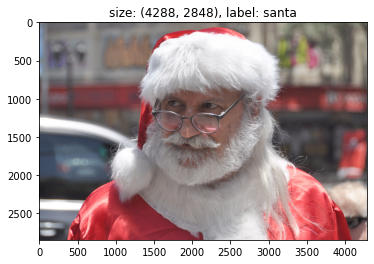

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 


for _ in range(3):
  # not in a chronological order but random images! 
  idx = np.random.randint(0, len(train_image_path))
  image = Image.open(train_image_path[idx])
  plt.imshow(image)
  plt.title(f"size: {image.size}, label: {train_image_path[idx].split('/')[7]}")
  plt.show()

Interesting images! 

As a next step, we could do image augmentation before training the model. 

But let's just try out first without image augmentation. Afterwards, we can try the second experiment with augmentation and compare the two results. 

# Data Preprocessing 

Here, we will use pretrained model, lets try with VGG16. Since images dataset have different sizes, we will resize them into 224 x 224 so that they can use as input data for the pretrained model.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

We will first define how we would like to transform our image dataset. 

- transforms.ToTensor: This is a very commonly used conversion transform. In PyTorch, we mostly work with data in the form of tensors. If the input data is in the form of a NumPy array or PIL image, we can convert it into a tensor format using ToTensor.The final tensor will be of the form (C * H * W). 

- This operation will take a tensor image and normalize it with mean and standard deviation. It has 3 parameters: mean, std, inplace. 
    - Example: torchvision.transforms.Normalize([meanOfChannel1, meanOfChannel2, meanOfChannel3], [stdOfChannel1, stdOfChannel2, stdOfChannel3])

reference: https://www.analyticsvidhya.com/blog/2021/04/10-pytorch-transformations-you-need-to-know/

In [ ]:
transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

We have defined our variable, transform. Let's apply it to out image dataset.

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        self.transform = transform
        self.data = data_path
        # If 1, then it is santa. 
        self.label = [int(p.split('/')[7] == 'santa') for p in data_path]
        self.data_len = len(self.data)
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, index):
        image = Image.open(self.data[index], mode='r')
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        self.label[index] = np.array(self.label[index])
        return image, torch.from_numpy(self.label[index])

In [ ]:
trainData = CustomDataset(train_image_path, transform=transform)
testData = CustomDataset(test_image_path, transform=transform)

Let's print out one sample that is turned into a tensor and scaled using our 'transform'.

Below, you can see the tensor of the first image and its label.

In [ ]:
testData[0]

(tensor([[[-0.5843, -0.5922, -0.6235,  ..., -0.4431, -0.5373, -0.5922],
          [-0.5843, -0.5922, -0.6157,  ..., -0.4431, -0.5216, -0.5922],
          [-0.5843, -0.5843, -0.6157,  ..., -0.4431, -0.5216, -0.5843],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ..., -0.5686,  0.3490,  0.9608],
          [ 0.8980,  0.8980,  0.9059,  ...,  0.6706,  0.9059,  0.9451],
          [ 0.7804,  0.7804,  0.7882,  ...,  0.9922,  0.9294,  1.0000]],
 
         [[-0.8902, -0.8824, -0.8824,  ..., -0.6157, -0.6863, -0.7333],
          [-0.8902, -0.8824, -0.8902,  ..., -0.6157, -0.6941, -0.7333],
          [-0.8902, -0.8902, -0.8902,  ..., -0.6157, -0.6863, -0.7412],
          ...,
          [ 0.7882,  0.7882,  0.7961,  ..., -0.7098,  0.2627,  0.9373],
          [ 0.6392,  0.6392,  0.6471,  ...,  0.6863,  0.9137,  0.9608],
          [ 0.4510,  0.4510,  0.4588,  ...,  0.9059,  0.8431,  1.0000]],
 
         [[-0.9294, -0.9294, -0.9216,  ..., -0.7961, -0.8039, -0.8118],
          [-0.9294, -0.9294,

We will use DataLoader to make batches. 

To create random batches, a good mix of True and False in every batch, we will use 'shuffle=True' FOR THE TRAINING DATASET. There is no need for the test datset.

In [ ]:
BATCH_SIZE = 54

trainLoader = torch.utils.data.DataLoader(trainData,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

testLoader = torch.utils.data.DataLoader(testData,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

# Model Preparation - VGG16
https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918


To train and test model with Pytorch, we need to define two methods - one for the training and another for testing.

In [ ]:
def train(model, trainLoader):
    model.to(device)
    model.train()
    train_loss = 0
    train_acc = 0
    for image, label in trainLoader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        loss = loss_fn(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (torch.argmax(output, dim=1) == label).sum().item()
        
    train_loss /= len(trainLoader)
    train_acc /= len(trainLoader.dataset)
    return train_loss, train_acc

In [ ]:
def test(model, testLoader):
    test_loss = 0
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for image, label in testLoader:
            image, label = image.to(device), label.to(device)
            output = model(image)
            loss = loss_fn(output, label)

            test_loss += loss.item()
            test_acc += (torch.argmax(output, dim=1) == label).sum().item()
        
    test_loss /= len(testLoader)
    test_acc /= len(testLoader.dataset)
    return test_loss, test_acc

Now lets define our model! 

In [ ]:
# Use pretrained GoogLeNet
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16 = vgg16.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# To check summary of model
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
summary(vgg16, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

You can see that the last layer has 1000 output neurons. 

> This is because the model was pretrained with ImageNet and this database has 1000 classes! 

Since we are dealing with a binary classification, we need to change the last layer of our model.

In [ ]:
vgg16.classifier 

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

We take the last layer which is -> vgg16.classifier[6]

In [ ]:
# change only the out_features!
vgg16.classifier[6] = nn.Linear(4096, 2)

We are almost prepared for the training! We need to define our loss function and optimizer.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(vgg16.parameters(), lr=1e-3)

# Train Model

Now we are all set up! Let's begin with our training.

In [ ]:
%%time
N_EPOCH = 10

for epoch in range(1, N_EPOCH+1):
    print(f'EPOCH {epoch}')
    loss, accuracy = train(vgg16, trainLoader)
    val_loss, val_accuracy = test(vgg16, testLoader)
    
    print('     Train | Loss : {:7.4f}, Accuracy : {:6.2f} %'.format(
        loss, accuracy*100))
    print('Validation | Loss : {:7.4f}, Accuracy : {:6.2f} %\n'.format(
        val_loss, val_accuracy*100))

EPOCH 1
     Train | Loss :  0.9404, Accuracy :  72.48 %
Validation | Loss :  0.4935, Accuracy :  75.81 %

EPOCH 2
     Train | Loss :  0.4552, Accuracy :  77.85 %
Validation | Loss :  0.6305, Accuracy :  65.58 %

EPOCH 3
     Train | Loss :  0.4328, Accuracy :  80.46 %
Validation | Loss :  0.3903, Accuracy :  82.31 %

EPOCH 4
     Train | Loss :  0.3143, Accuracy :  87.13 %
Validation | Loss :  0.4228, Accuracy :  81.49 %

EPOCH 5
     Train | Loss :  0.3011, Accuracy :  86.48 %
Validation | Loss :  0.3505, Accuracy :  86.36 %

EPOCH 6
     Train | Loss :  0.2780, Accuracy :  89.09 %
Validation | Loss :  0.3715, Accuracy :  82.79 %

EPOCH 7
     Train | Loss :  0.2690, Accuracy :  89.74 %
Validation | Loss :  0.3602, Accuracy :  84.74 %

EPOCH 8
     Train | Loss :  0.2177, Accuracy :  90.72 %
Validation | Loss :  0.3511, Accuracy :  87.34 %

EPOCH 9
     Train | Loss :  0.2021, Accuracy :  92.51 %
Validation | Loss :  0.4011, Accuracy :  84.74 %

EPOCH 10
     Train | Loss :  0.2171,

# Test Model

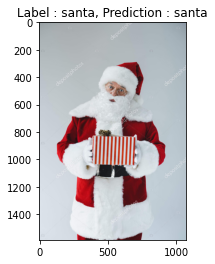

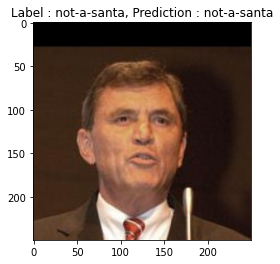

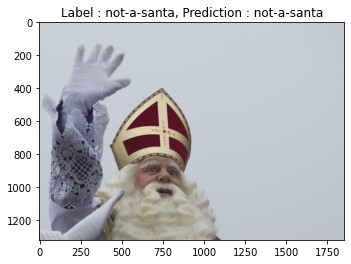

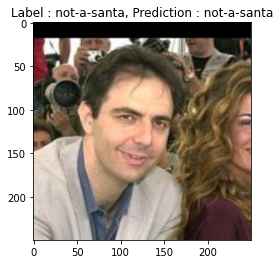

In [ ]:
for _ in range(4):
    rnd_idx = np.random.randint(0, len(test_image_path))
    label = test_image_path[rnd_idx].split('/')[-2]
    image_path = test_image_path[rnd_idx]

    image = Image.open(image_path, mode='r')
    test_image = image.convert('RGB')
    test_image = transform(test_image)

    prediction = vgg16(torch.unsqueeze(test_image.to(device), 0))
    pred_label = 'santa' if torch.argmax(prediction, dim=1).item() == 1 else 'not-a-santa'
    
    plt.title(f'Label : {label}, Prediction : {pred_label}')
    plt.imshow(image)
    plt.show()